In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import time
import os

In [2]:
offers = pd.read_csv('./datasets/data_offers.csv')
orders = pd.read_csv('./datasets/data_orders.csv')

In [3]:
orders['order_datetime'] = pd.to_datetime(orders['order_datetime'], format='%H:%M:%S')
orders['order_datetime'] = orders['order_datetime'].dt.strftime('%H')
orders.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
0,18,-0.978916,51.456173,60.0,3000583041974,4,1,198.0
1,20,-0.950385,51.456843,NaN,3000583116437,4,0,128.0
2,12,-0.969520,51.455544,477.0,3000582891479,4,1,46.0
3,13,-1.054671,51.460544,658.0,3000582941169,4,1,62.0
4,21,-0.967605,51.458236,NaN,3000583140877,9,0,NaN


## Task1 
Build up distribution of orders according to reasons for failure: cancellations before and after driver assignment, and reasons for order rejection. Analyse the resulting plot. Which category has the highest number of orders?

In [4]:
canceled_order = orders.dropna(subset=['order_status_key']) #筛选出取消的订单
total_records = canceled_order['order_datetime'].count()

order_status_keyorder_status_key #4 顾客取消, #9 系统拒单  
is_driver_assigned_key 是否已委派司机  
m_order_eta - 等待时间#已委派司机的情况才有  
cancellations_time_in_seconds 订单取消前过了多久  
- `order_status_key` = 4 && `is_driver_assigned_key` = True && check `m_order_eta`&`cancellations_time_in_seconds` 顾客取消&已委派司机--检查等待时间和取消订单时间  
- `order_status_key` = 4 && `is_driver_assigned_key` = False && check `cancellations_time_in_seconds`顾客取消&未委派司机--检查取消订单时间  
- `order_status_key` = 9

In [5]:
# 系统拒单
rejected_order = orders[orders['order_status_key'] == 9]
rejected_order.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
4,21,-0.967605,51.458236,NaN,3000583140877,9,0,NaN
5,21,-0.947011,51.456380,NaN,3000583117054,9,0,NaN
6,07,-0.955637,51.470372,NaN,3000582791789,9,0,NaN
7,07,-0.978230,51.454575,NaN,3000582791562,9,0,NaN
8,08,-1.052298,51.454308,NaN,3000582817606,9,0,NaN


In [6]:
# 顾客取消&已委派司机
assigned_order = canceled_order[canceled_order['is_driver_assigned_key'] == 1] #发现只要已委派司机，那必定是顾客取消订单
print(assigned_order.shape)
assigned_order.head()

(2814, 8)


,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
0,18,-0.978916,51.456173,60.0,3000583041974,4,1,198.0
2,12,-0.969520,51.455544,477.0,3000582891479,4,1,46.0
3,13,-1.054671,51.460544,658.0,3000582941169,4,1,62.0
13,16,-0.950683,51.451368,538.0,3000583016613,4,1,188.0
14,00,-0.937006,51.448696,179.0,3000582566041,4,1,316.0


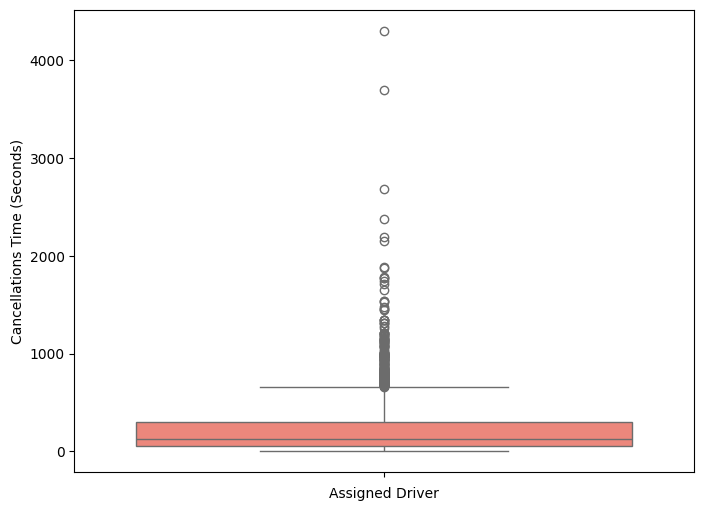

In [11]:
plt.figure(figsize=(8, 6))  # 设置图形大小  
sns.boxplot(data=assigned_order['cancellations_time_in_seconds'], color='#FF7869')
plt.xlabel('Assigned Driver')  # 设置x轴标签  
plt.ylabel('Cancellations Time (Seconds)')  # 设置y轴标签  
plt.show()

In [8]:
# 顾客取消&未委派司机
not_assigned_order = canceled_order[(canceled_order['is_driver_assigned_key'] == 0) & (canceled_order['order_status_key'] == 4)]
print(not_assigned_order.shape)
not_assigned_order.head()

(4496, 8)


,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
1,20,-0.950385,51.456843,NaN,3000583116437,4,0,128.0
9,06,-0.976216,51.433202,NaN,3000582765616,4,0,78.0
10,15,-0.934670,51.447065,NaN,3000582991062,4,0,167.0
11,20,-0.972735,51.452489,NaN,3000583116472,4,0,45.0
12,06,-0.958791,51.459481,NaN,3000582765488,4,0,79.0


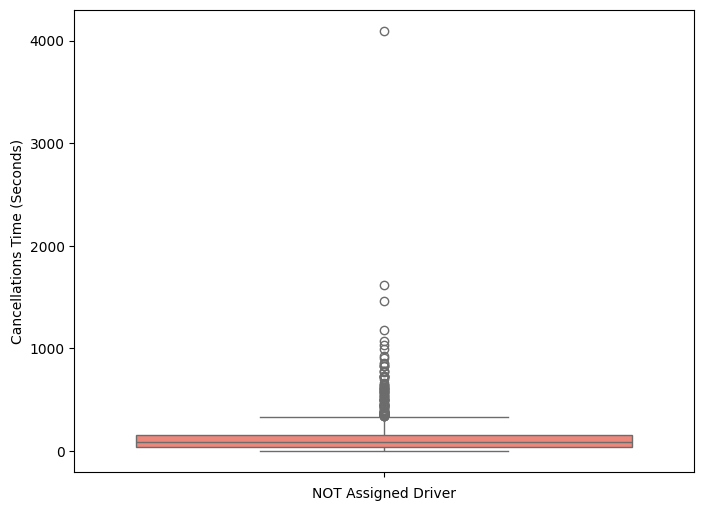

In [12]:
plt.figure(figsize=(8, 6))  # 设置图形大小  
sns.boxplot(data=not_assigned_order['cancellations_time_in_seconds'], color='#FF7869')
plt.xlabel('NOT Assigned Driver')  # 设置x轴标签  
plt.ylabel('Cancellations Time (Seconds)')  # 设置y轴标签  
plt.show()

In [13]:
reject_cnt = rejected_order['order_status_key'].count()
assigned_cnt = assigned_order['order_status_key'].count()
not_assigned_cnt = not_assigned_order['order_status_key'].count()
data = {'category': ['Reject by System', 'Assigned Driver \n (too far away)', 'Not Assigned Driver \n (wait too long)'], 'count': [reject_cnt, assigned_cnt, not_assigned_cnt]}
df_data = pd.DataFrame(data)

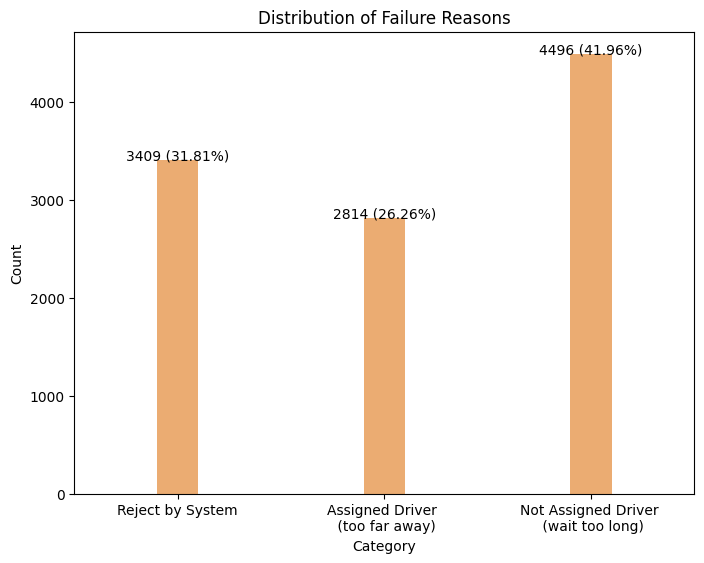

In [14]:
plt.figure(figsize=(8, 6))
# 使用 seaborn 绘制条形图  
barplot = sns.barplot(x='category', y='count', data=df_data, width=0.2, color='#FFAB5E')  

for p in barplot.patches:  
    # 获取条形的高度  
    height = p.get_height()  
    # 获取条形的 x 位置  
    x = p.get_x() + p.get_width() / 2  
    plt.text(x, height+0.5, f'{height:.0f} ({height * 100 / total_records :.2f}%)', ha='center') 

# 设置图形标题和轴标签  
plt.title('Distribution of Failure Reasons')  
plt.xlabel('Category')  
plt.ylabel('Count')  
  
# 显示图形  
plt.show()

## Task2
Plot the distribution of failed orders by hours. Is there a trend that certain hours have an abnormally high proportion of one category or another? What hours are the biggest fails? How can this be explained?

In [15]:
hours = []
for hour in range(24):  
    if hour < 10:
        hour_str = f'0{hour}'
    else:
        hour_str = f'{hour}'
    hours.append(hour_str)
print(hours)

['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23']


In [16]:
# 按小时记录两种拒单的数量
assigned_hours = []
not_assigned_hours = []
rejected_hours = []
for hour in hours:
    # 先按时间筛选
    assigned_hour = assigned_order[assigned_order['order_datetime'] == hour]
    not_assigned_hour = not_assigned_order[not_assigned_order['order_datetime'] == hour]
    rejected_hour = rejected_order[rejected_order['order_datetime'] == hour]

    assigned_hours.append(assigned_hour['order_datetime'].count())
    not_assigned_hours.append(not_assigned_hour['order_datetime'].count())
    rejected_hours.append(rejected_hour['order_datetime'].count())
total_cnt = [a + b + c for a, b, c in zip(assigned_hours, not_assigned_hours, rejected_hours)] # 每小时取消总订单量

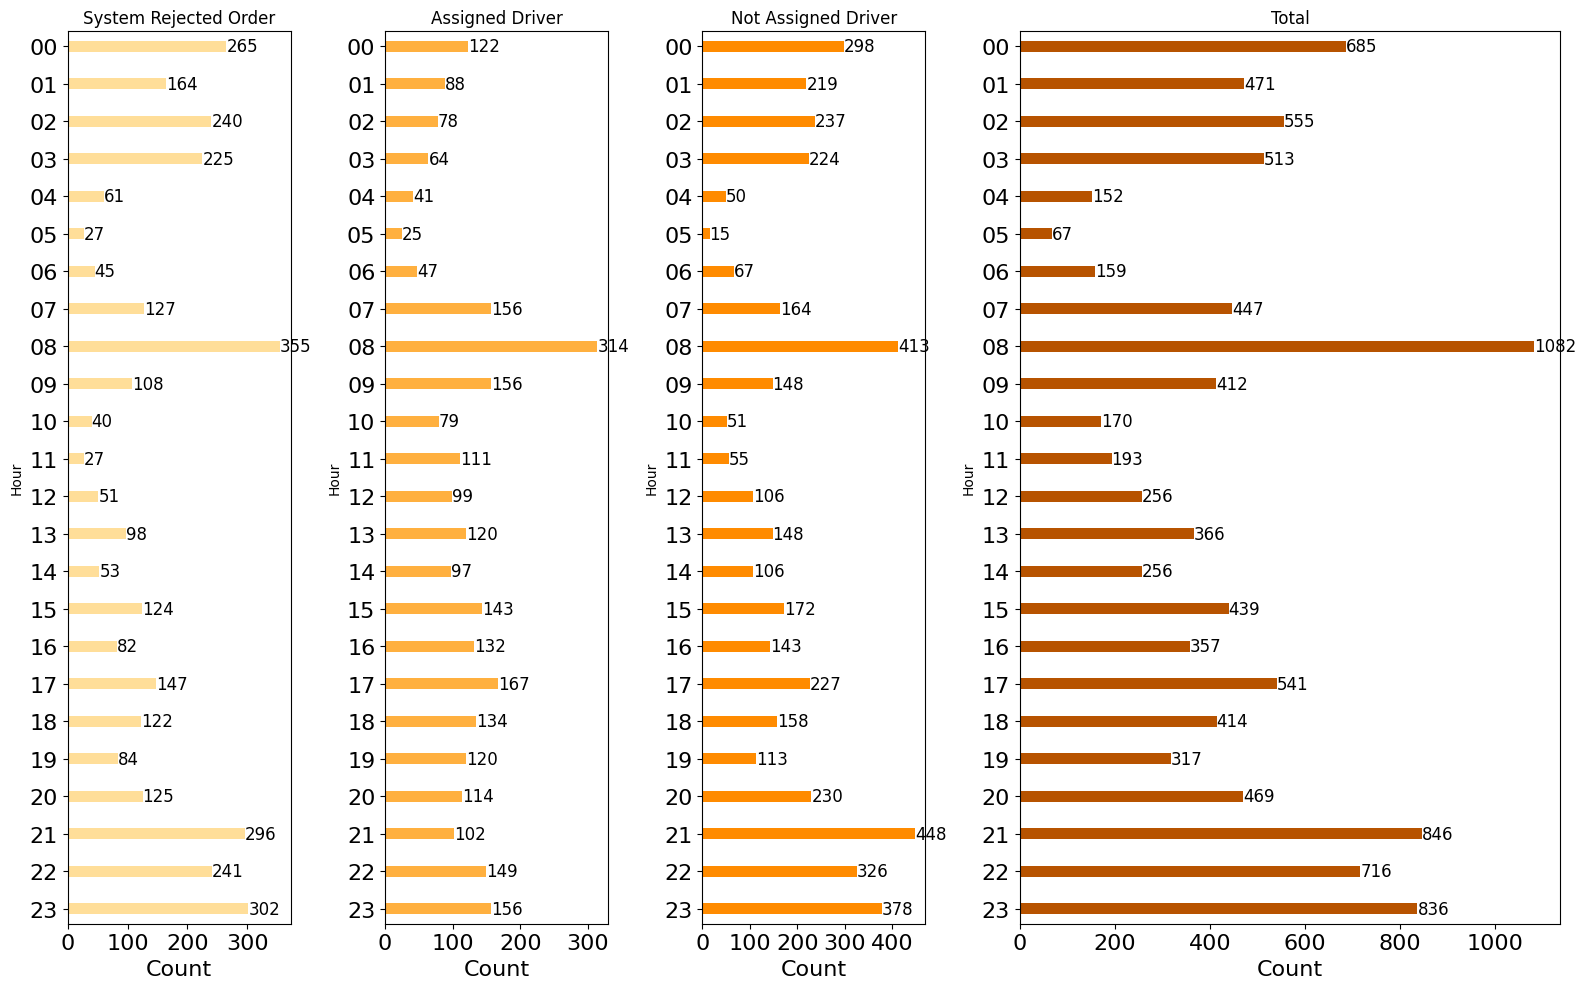

In [17]:
data_hours = {'hours': hours,'System Rejected Order':rejected_hours, 'Assigned Driver': assigned_hours, 'Not Assigned Driver': not_assigned_hours, 'Total': total_cnt}
df_hours = pd.DataFrame(data_hours)

# 创建包含多个子图的图形
fig = plt.figure(figsize=(16, 10))
grid = gridspec.GridSpec(1, 5, figure=fig, width_ratios=[1, 1, 1, 1, 1])
ax1 = fig.add_subplot(grid[0, 0])
ax2 = fig.add_subplot(grid[0, 1])
ax3 = fig.add_subplot(grid[0, 2])
ax4 = fig.add_subplot(grid[0, 3:5])
axes = [ax1, ax2, ax3, ax4]

colors = ['#FFDE99', '#FFB03F', '#ff8b00', '#B75300']

# 设置 country 列为索引
df_hours.set_index('hours', inplace=True)

# 绘制多个横向堆叠条形图
for idx, column in enumerate(df_hours.columns):
    ax = axes[idx]
    df_hours[[column]].plot(kind='barh', stacked=True, ax=ax, color=colors[idx], width=0.3,fontsize = 16, legend=None)
    ax.set_title(column, fontsize = 12)
    ax.set_xlabel('Count', fontsize = 16)
    ax.set_ylabel('Hour')
    ax.invert_yaxis()  # 反转 y 轴顺序

    # 在子图上显示数据
    for i, v in enumerate(df_hours[column]):
        ax.text(v, i, f'{v:.0f}', va='center', ha='left', fontsize = 12)



plt.tight_layout()
# 保存图片到指定位置
plt.show()

## Task3
Plot the average time to cancellation with and without driver, by the hour. If there are any outliers in the data, it would be better to remove them. Can we draw any conclusions from this plot?

In [18]:
# 按小时记录两种拒单的取消等待时长
assigned_hours = []
not_assigned_hours = []
for hour in hours:
    # 先按时间筛选
    assigned_hour = assigned_order[assigned_order['order_datetime'] == hour]
    not_assigned_hour = not_assigned_order[not_assigned_order['order_datetime'] == hour]
    # 使用IQR来识别离群值  
    Q1_a = assigned_hour['cancellations_time_in_seconds'].quantile(0.25)  
    Q3_a = assigned_hour['cancellations_time_in_seconds'].quantile(0.75)  
    IQR_a = Q3_a - Q1_a
    
    Q1_n = not_assigned_hour['cancellations_time_in_seconds'].quantile(0.25)  
    Q3_n = not_assigned_hour['cancellations_time_in_seconds'].quantile(0.75)  
    IQR_n = Q3_n - Q1_n 

    # 定义离群值的界限
    lower_bound_a = Q1_a - 1.5 * IQR_a
    upper_bound_a = Q3_a + 1.5 * IQR_a
    
    lower_bound_n = Q1_n - 1.5 * IQR_n
    upper_bound_n = Q3_n + 1.5 * IQR_n

    # 筛选非异常值（即位于界限内的值）  
    ass_non_outliers = assigned_hour[(assigned_hour['cancellations_time_in_seconds'] >= lower_bound_a) & (assigned_hour['cancellations_time_in_seconds'] <= upper_bound_a)]
    not_non_outliers = not_assigned_hour[(not_assigned_hour['cancellations_time_in_seconds'] >= lower_bound_n) & (not_assigned_hour['cancellations_time_in_seconds'] <= upper_bound_n)]

    assigned_hours.append(ass_non_outliers['cancellations_time_in_seconds'].mean())
    not_assigned_hours.append(not_non_outliers['cancellations_time_in_seconds'].mean())

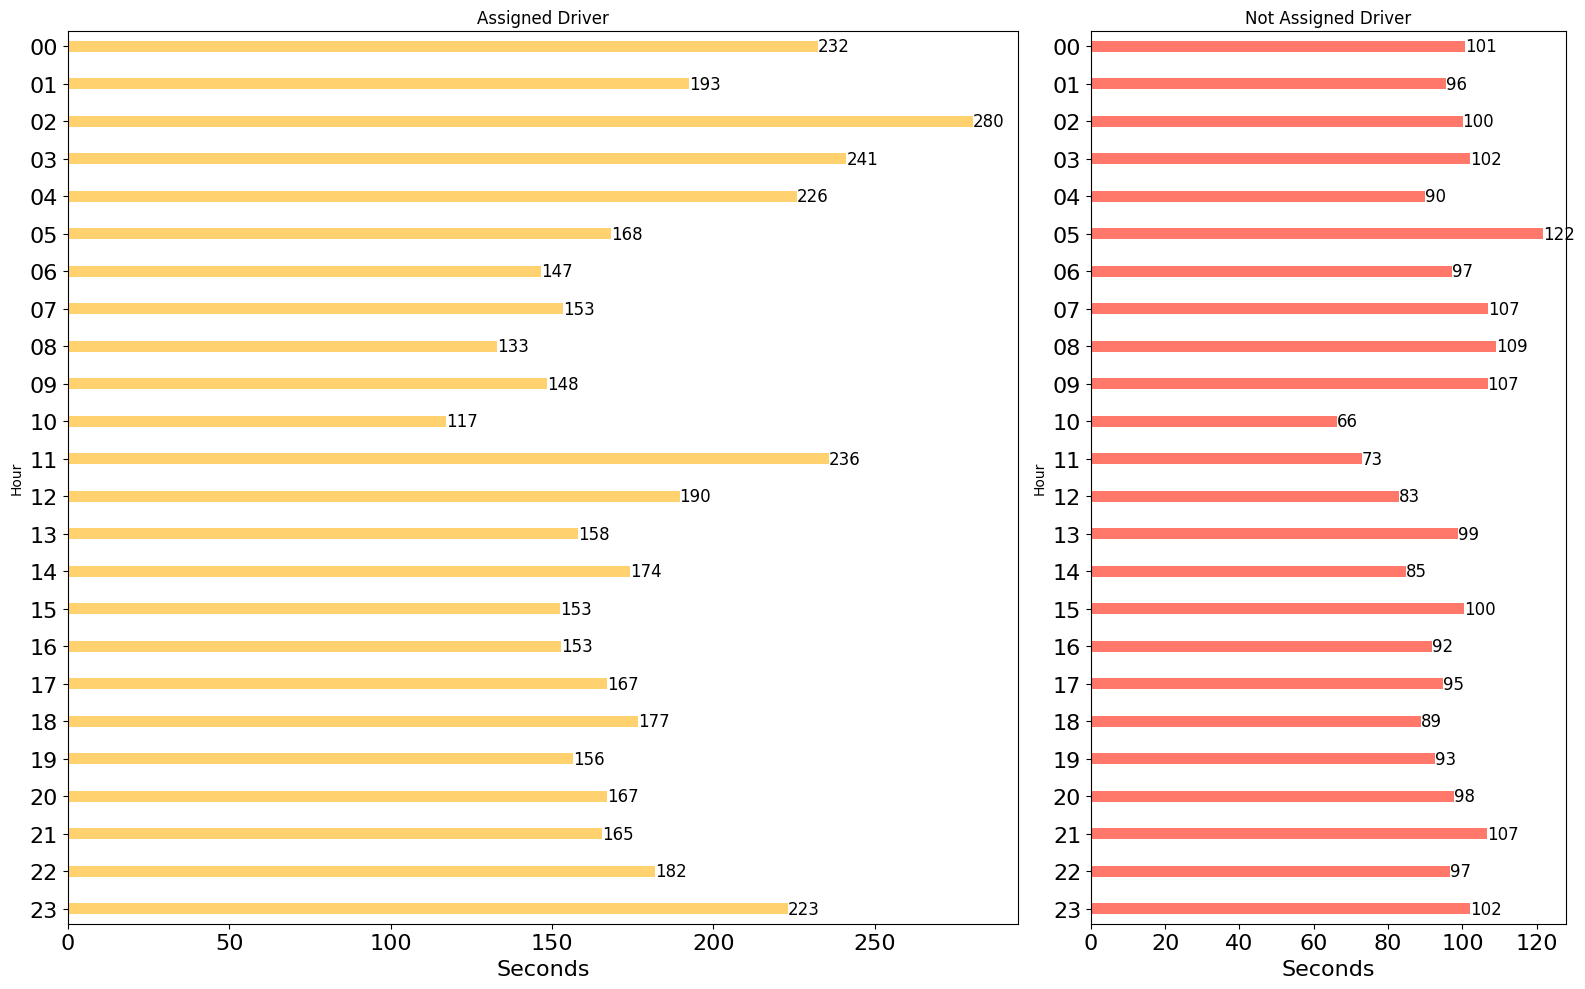

In [20]:
avg_hours = {'hours': hours, 'Assigned Driver': assigned_hours, 'Not Assigned Driver': not_assigned_hours}
df_hours = pd.DataFrame(avg_hours)

# 创建包含多个子图的图形
fig = plt.figure(figsize=(16, 10))
grid = gridspec.GridSpec(1, 2, figure=fig, width_ratios=[2, 1])
ax1 = fig.add_subplot(grid[0, 0])
ax2 = fig.add_subplot(grid[0, 1])
axes = [ax1, ax2]

colors = ['#FFD16F', '#FF7869', '#4A4165', '#362D54', '#241C44']

# 设置 country 列为索引
df_hours.set_index('hours', inplace=True)

# 绘制多个横向堆叠条形图
for idx, column in enumerate(df_hours.columns):
    ax = axes[idx]
    df_hours[[column]].plot(kind='barh', stacked=True, ax=ax, color=colors[idx], width=0.3,fontsize = 16, legend=None)
    ax.set_title(column, fontsize = 12)
    ax.set_xlabel('Seconds', fontsize = 16)
    ax.set_ylabel('Hour')
    ax.invert_yaxis()  # 反转 y 轴顺序

    # 在子图上显示数据
    for i, v in enumerate(df_hours[column]):
        ax.text(v, i, f'{v:.0f}', va='center', ha='left', fontsize = 12)

plt.tight_layout()
plt.show()

## Task4
Plot the distribution of average ETA by hours. How can this plot be explained?

In [32]:
# 先筛选非空eta
df_eta = orders.dropna(subset='m_order_eta')
df_eta.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
0,18,-0.978916,51.456173,60.0,3000583041974,4,1,198.0
2,12,-0.969520,51.455544,477.0,3000582891479,4,1,46.0
3,13,-1.054671,51.460544,658.0,3000582941169,4,1,62.0
13,16,-0.950683,51.451368,538.0,3000583016613,4,1,188.0
14,00,-0.937006,51.448696,179.0,3000582566041,4,1,316.0


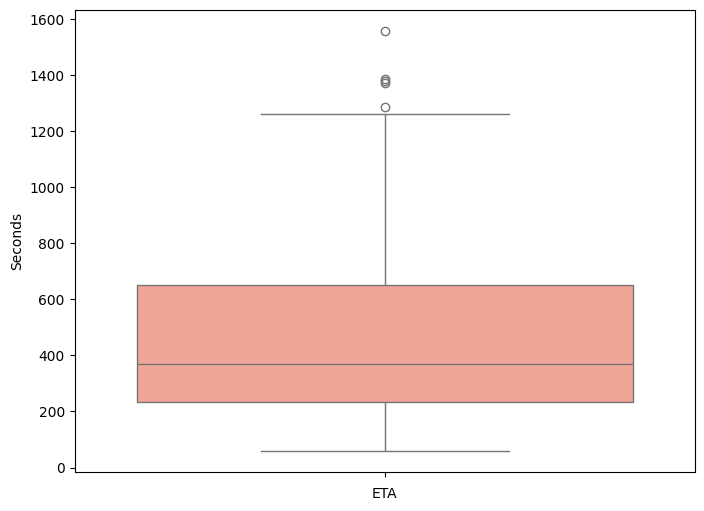

In [33]:
# 先选择一个时间段测试是否存在离群值
# 
eta_hour = df_eta
eta_10 = eta_hour['m_order_eta']

plt.figure(figsize=(8, 6))  # 设置图形大小  
sns.boxplot(data=eta_10, color='#FF9D87')
plt.xlabel('ETA')  # 设置x轴标签  
plt.ylabel('Seconds')  # 设置y轴标签  
plt.show()

In [34]:
# 按小时记录ETA
eta_hours = []
for hour in hours:
    # 先按时间筛选
    eta_hour = df_eta[df_eta['order_datetime'] == hour]

    eta_hours.append(eta_hour['m_order_eta'].mean())

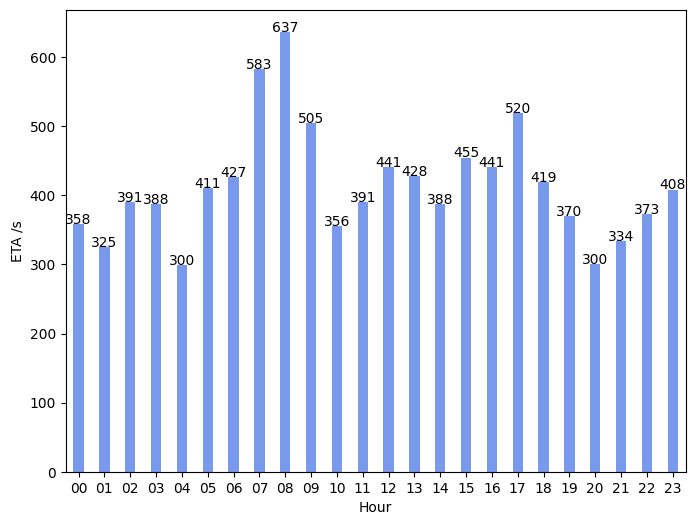

In [35]:
data_eta = {'hour': hours, 'avg_eta': eta_hours}
fig_data_eta = pd.DataFrame(data_eta)
plt.figure(figsize=(8, 6))
# 使用 seaborn 绘制条形图  
barplot = sns.barplot(x='hour', y='avg_eta', data=fig_data_eta, width=0.4, color='#6690FF')  

for p in barplot.patches:  
    # 获取条形的高度  
    height = p.get_height()  
    # 获取条形的 x 位置  
    x = p.get_x() + p.get_width() / 2  
    plt.text(x, height+0.5, f'{height:.0f}', ha='center') 

# 设置图形标题和轴标签 
plt.xlabel('Hour')  
plt.ylabel('ETA /s')  
  
# 显示图形  
plt.show()

## BONUS Hexagons.
Using the h3 and folium packages, calculate how many sizes 8 hexes contain 80% of all orders from the original data sets and visualise the hexes, colouring them by the number of fails on the map.

In [36]:
import h3
import folium

In [38]:
# Step 3: Calculate H3 Hexagons
# Convert latitude and longitude to H3 hexagons
def convert_to_h3(lat, lon, resolution=8):
    return h3.geo_to_h3(lat, lon, resolution)

# Apply the function to your DataFrame
canceled_order.loc[:, 'h3_hex'] = canceled_order.apply(lambda row: convert_to_h3(row['origin_latitude'], row['origin_longitude']), axis=1)

# Step 4: Count Orders in Each Hexagon
# Use groupby to count orders in each hexagon
hexagon_counts = canceled_order.groupby('h3_hex').size().reset_index(name='order_count')

# Step 5: Calculate Cumulative Percentage
# Sort hexagons by order count
hexagon_counts = hexagon_counts.sort_values(by='order_count', ascending=False)
# Calculate cumulative percentage
hexagon_counts['cumulative_percentage'] = hexagon_counts['order_count'].cumsum() / hexagon_counts['order_count'].sum()

# Step 6: Find Hexagons Containing 80% of Orders
# Get the hexagons containing 80% of orders
top_hexagons = hexagon_counts[hexagon_counts['cumulative_percentage'] <= 0.8]

# Step 7: Visualize Hexagons
# Calculate mean latitude and longitude
mean_latitude = canceled_order['origin_latitude'].mean()
mean_longitude = canceled_order['origin_longitude'].mean()

# Create a folium map
m = folium.Map(location=[mean_latitude, mean_longitude], zoom_start=10)

# Add hexagons to the map
for idx, row in top_hexagons.iterrows():
    lat, lon = h3.h3_to_geo(row['h3_hex'])
    count = row['order_count']
    folium.RegularPolygonMarker(location=[lat, lon], fill_color='#dd7a02', number_of_sides=6, radius=10, popup=str(count)).add_to(m)

# Display the map
m.save('./hexagon_map.html')



In [42]:
# Step 3: Calculate H3 Hexagons
# Convert latitude and longitude to H3 hexagons
def convert_to_h3(lat, lon, resolution=8):
    return h3.geo_to_h3(lat, lon, resolution)

# Apply the function to your DataFrame
canceled_order.loc[:, 'h3_hex'] = canceled_order.apply(lambda row: convert_to_h3(row['origin_latitude'], row['origin_longitude']), axis=1)

# Step 4: Count Orders in Each Hexagon
# Use groupby to count orders in each hexagon
hexagon_counts = canceled_order.groupby('h3_hex').size().reset_index(name='order_count')

# Step 5: Calculate Cumulative Percentage
# Sort hexagons by order count
hexagon_counts = hexagon_counts.sort_values(by='order_count', ascending=False)
# Calculate cumulative percentage
hexagon_counts['cumulative_percentage'] = hexagon_counts['order_count'].cumsum() / hexagon_counts['order_count'].sum()

# Step 6: Find Hexagons Containing 80% of Orders
# Get the hexagons containing 80% of orders
top_hexagons = hexagon_counts[hexagon_counts['cumulative_percentage'] <= 0.8]
# Step 7: Visualize Hexagons
# Calculate mean latitude and longitude
mean_latitude = canceled_order['origin_latitude'].mean()
mean_longitude = canceled_order['origin_longitude'].mean()

# Create a folium map
m = folium.Map(location=[mean_latitude, mean_longitude], zoom_start=10)

# Add hexagons to the map
for idx, row in top_hexagons.iterrows():
    lat, lon = h3.h3_to_geo(row['h3_hex'])
    count = row['order_count']
    percentage = row['cumulative_percentage']
    
    # Calculate color based on cumulative percentage
    color = '#ADC8FF'  # Default color
    if percentage > 0.5:
        color = '#ff5733'  # Change color for higher cumulative percentages
        
    # Adjust border color based on cumulative percentage
    border_color = '#000000'  # Default border color
    if percentage > 0.7:
        border_color = '#ff0000'  # Change border color for higher cumulative percentages
        
    # Add hexagon marker to the map
    folium.RegularPolygonMarker(
        location=[lat, lon],
        fill_color=color,
        fill_opacity=0.7,
        number_of_sides=6,
        radius=10,
        popup=f"Order Count: {count}, Cumulative Percentage: {percentage:.2f}",
        color=border_color,  # Set border color
        weight=2  # Adjust border width
    ).add_to(m)

# Create a custom legend
legend_html = '''
     <div style="position: fixed; 
                 bottom: 50px; left: 50px; width: 200px; height: 120px; 
                 border:2px solid grey; z-index:9999; font-size:10px;
                 background-color: white;
                 opacity: 0.8;
                 ">
     &nbsp; <strong>Legend</strong> <br>
     &nbsp; Cumulative Percentage > 50%: <i style="background:#ff5733;opacity:1"></i> <br>
     &nbsp; Cumulative Percentage > 70%: <i style="background:#ff0000;opacity:1"></i> <br>
      </div>
     '''

# Add the legend to the map
m.get_root().html.add_child(folium.Element(legend_html))
# Display the map
m.save('./hexagon_map.html')
